In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator
from numpy import array

# Data Loading

In [2]:
filename = 'NotFinishedOnTimeContext'

In [3]:
dataset= pd.read_csv(filename + ".csv")
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [7]:
gluon_dataset_copy

ds           y
0   2021-02-18 11:32:12.752  525.500000
1   2021-02-18 11:33:12.752  555.500000
2   2021-02-18 11:34:12.752  585.500000
3   2021-02-18 11:35:12.752  723.250000
4   2021-02-18 11:36:12.752  753.250000
..                      ...         ...
134 2021-02-18 13:46:12.752  610.500000
135 2021-02-18 13:47:12.752  590.156250
136 2021-02-18 13:48:12.752  579.140625
137 2021-02-18 13:49:12.752  595.359375
138 2021-02-18 13:50:12.752  590.765625

[139 rows x 2 columns]

In [6]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Data Transformation

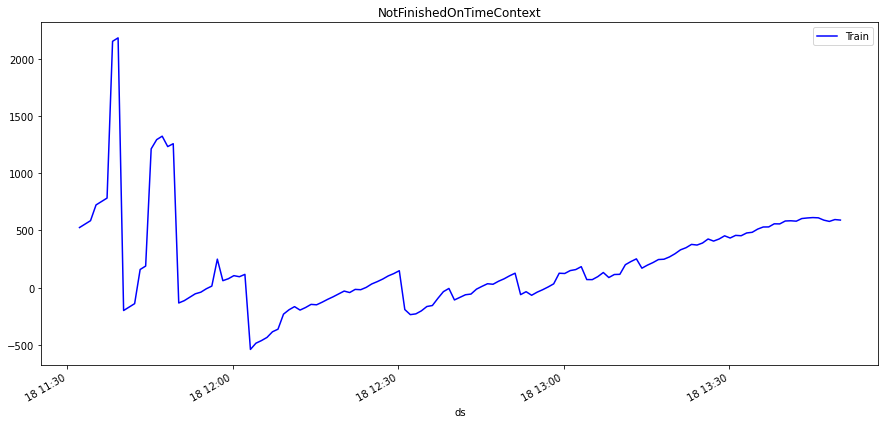

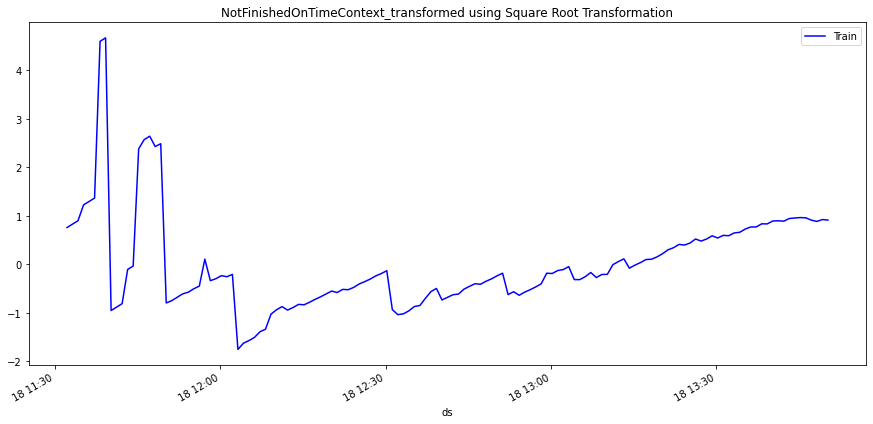

In [8]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
gluon_dataset_copy['y_orig']=gluon_dataset_copy['y']
data = array(gluon_dataset_copy['y']).reshape(len(gluon_dataset_copy['y']), 1)
transformer.fit(data)
transformed = transformer.transform(data)
gluon_dataset_copy['y']=transformed


#transformed = cube_root_transformation(gluon_dataset_copy['y'])
#gluon_dataset_copy['y']=transformed

#plot before transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y_orig', color='blue', label='Train', ax=ax)
plt.title(filename)
plt.show()

#plot after transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
#test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title(filename + "_transformed using Square Root Transformation")
plt.show()

In [9]:
gluon_dataset_copy

ds         y      y_orig
0   2021-02-18 11:32:12.752  0.759409  525.500000
1   2021-02-18 11:33:12.752  0.830149  555.500000
2   2021-02-18 11:34:12.752  0.900890  585.500000
3   2021-02-18 11:35:12.752  1.225707  723.250000
4   2021-02-18 11:36:12.752  1.296447  753.250000
..                      ...       ...         ...
134 2021-02-18 13:46:12.752  0.959840  610.500000
135 2021-02-18 13:47:12.752  0.911869  590.156250
136 2021-02-18 13:48:12.752  0.885894  579.140625
137 2021-02-18 13:49:12.752  0.924138  595.359375
138 2021-02-18 13:50:12.752  0.913306  590.765625

[139 rows x 3 columns]

# Splitting Data into Training and Testing

In [10]:
gluon_dataset_copy=gluon_dataset.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-18 13:10:00"
train_time = "2021-02-18 13:30:00"
test_time = "2021-02-18 13:50:12"
freq='1min'

In [11]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )
test_orig_ds = ListDataset([{"start":gluon_dataset.index[0],
                        "target":gluon_dataset.y[:test_time]}],
                        freq=freq
                     )

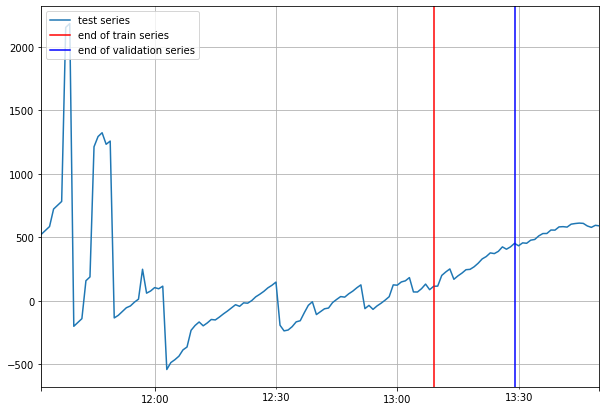

In [12]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_orig_entry = next(iter(test_orig_ds))
test_orig_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [13]:
prediction_length

21

# Hyper-parameter Tuning

In [14]:
batch_size = [75,100]
epochs = [5,10]
num_batches_per_epoch = [10,20]
learning_rate = [1e-3,1e-4]

In [15]:
from sklearn.model_selection import ParameterGrid

param_grid = {#'num_hidden_dimensions':num_hidden_dimensions,
              'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 32


In [16]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = DeepAREstimator(
                        #num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    #agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


              MSE    abs_error  abs_target_sum  abs_target_mean  \
0   117737.964286  6570.323242     6088.288086        289.91848   
1    85666.196429  5365.520020     6088.288086        289.91848   
2    90670.214286  6018.841309     6088.288086        289.91848   
3    86758.470238  5840.668945     6088.288086        289.91848   
4    98430.922619  5871.807129     6088.288086        289.91848   
5   121836.690476  6768.024414     6088.288086        289.91848   
6    82980.726190  5410.670410     6088.288086        289.91848   
7    94744.261905  5749.183594     6088.288086        289.91848   
8    79183.178571  5035.664551     6088.288086        289.91848   
9   116543.845238  6174.261230     6088.288086        289.91848   
10   92810.940476  5884.616699     6088.288086        289.91848   
11  104624.678571  6175.319336     6088.288086        289.91848   
12   69605.434524  4291.475586     6088.288086        289.91848   
13  115422.809524  6032.546387     6088.288086        289.9184

# Forecast and Evaluation

In [17]:
estimator = DeepAREstimator(
    #num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)

In [18]:
predictor = estimator.train(train_ds)

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 20/20 [00:02<00:00,  8.32it/s, epoch=10/10, avg_epoch_loss=5.74]


# Save the Model 

In [19]:
from pathlib import Path
predictor.serialize(Path("Models/Standardization"))

# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("Models/CubeRoot"))
# print(predictor_deserialized)

In [20]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



In [21]:
#return forecast to original
#inv = np.vectorize(log_inverse_transformation)

forecast_entry.samples=transformer.inverse_transform(forecast_entry.samples)
#forecast_entry.samples = inv(forecast_entry.samples)
forecast_entry_inv=SampleForecast(freq=freq, start_date=forecast_entry.start_date, samples=forecast_entry.samples)

forecast_entry_val.samples = transformer.inverse_transform(forecast_entry_val.samples)
forecast_entry_val_inv=SampleForecast(freq=freq, start_date=forecast_entry_val.start_date, samples=forecast_entry_val.samples)

ts_entry_inv=transformer.inverse_transform(ts_entry)
ts_entry_inv_df=pd.DataFrame(ts_entry_inv, index=ts_entry.index)
tss_inv=list()
tss_inv.append(ts_entry_inv_df)

In [22]:
tss_inv

[                                 0
 2021-02-18 11:32:00  223060.265625
 2021-02-18 11:33:00  235782.812500
 2021-02-18 11:34:00  248505.375000
 2021-02-18 11:35:00  306923.093750
 2021-02-18 11:36:00  319645.656250
 ...                            ...
 2021-02-18 13:46:00  259107.515625
 2021-02-18 13:47:00  250480.031250
 2021-02-18 13:48:00  245808.453125
 2021-02-18 13:49:00  252686.593750
 2021-02-18 13:50:00  250738.453125
 
 [139 rows x 1 columns]]

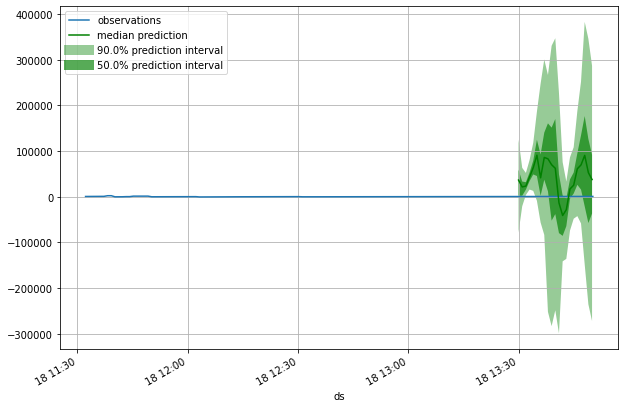

In [23]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(ts_entry)
    prediction_intervals = (50.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry_inv)

In [24]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss_inv), iter([forecast_entry_inv]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


In [25]:
agg_metrics

{'MSE': 39121122255.2381,
 'abs_error': 4004098.25,
 'abs_target_sum': 4896739.0,
 'abs_target_mean': 233178.04761904763,
 'seasonal_error': 41377.756410256414,
 'MASE': 4.60806389180717,
 'MAPE': 0.813979377241728,
 'sMAPE': 1.3655317174838204,
 'OWA': nan,
 'MSIS': 55.22616170895733,
 'QuantileLoss[0.1]': 1250104.390625,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 4004098.3828125,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.9]': 3374719.24375,
 'Coverage[0.9]': 0.23809523809523808,
 'RMSE': 197790.6020397281,
 'NRMSE': 0.848238520132335,
 'ND': 0.8177071005826531,
 'wQuantileLoss[0.1]': 0.2552932452852807,
 'wQuantileLoss[0.5]': 0.8177071277052953,
 'wQuantileLoss[0.9]': 0.6891768672477745,
 'mean_absolute_QuantileLoss': 2876307.3390625003,
 'mean_wQuantileLoss': 0.5873924134127835,
 'MAE_Coverage': 0.42063492063492064}

# Residual

In [26]:
#get the mean for all the samples
f1 = forecast_entry_val_inv.samples.mean(axis=0)
f2 = forecast_entry_inv.samples.mean(axis=0)

In [27]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [28]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


Text(0.5, 1.0, 'Residuals')

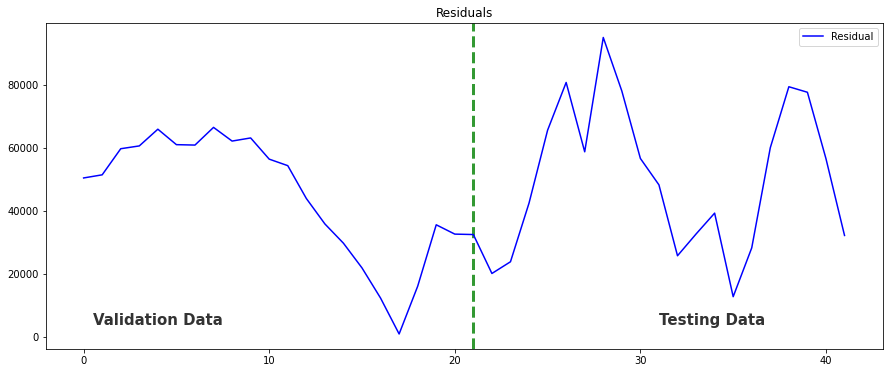

In [29]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=4000, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=4000, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

# Save the Predictions

In [30]:
predictions_df=pd.DataFrame()
predictions_df['original'] = valandtest_orig
predictions_df['predictions'] = valandtest_pred
predictions_df.to_csv(Path("Predictions/Standardization.csv"),index=False)